Enter the value of K:1


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


NameError: name 'cord' is not defined

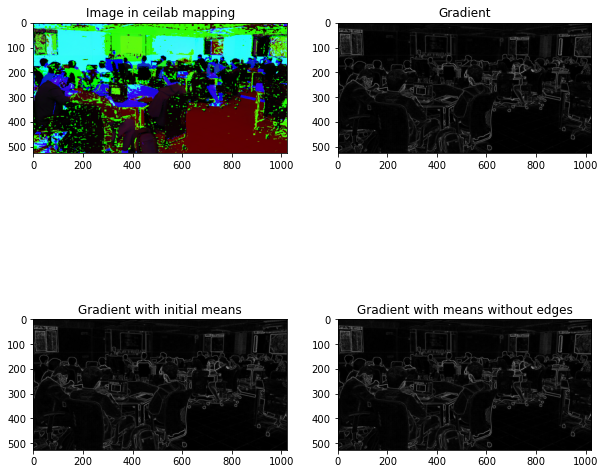

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from skimage import color
from tqdm import tqdm
from PIL import Image
import PIL
from tkinter import *
from tkinter import messagebox
from PIL import ImageTk, Image
from tkinter import filedialog

def openfn():  #Function to get the file name(location)
    filename = filedialog.askopenfilename(title='open')
    return filename

img = cv2.imread(openfn(),1)
img = cv2.resize(img,(int(img.shape[1]*0.5),int(img.shape[0]*0.5)),interpolation = cv2.INTER_AREA)
lab = color.rgb2lab(img)

N = img.shape[0]*img.shape[1]
K = int(input("Enter the value of K:"))
S = math.sqrt(N/K)

# Creating the grid with S as spacing
cod = []
frame = np.zeros((img.shape[0],img.shape[1]))
for x in range(int(S),img.shape[0],int(S)):
    for y in range(int(S),img.shape[1],int(S)):
        cod.append([x,y])
        frame[x,y] = 255

#Calculating the gradient image
grad = np.zeros((img.shape[0],img.shape[1]))
figure=plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(np.uint8(lab))
plt.title('Image in ceilab mapping')

for x in range(1,img.shape[0]-1):
    for y in range(1,img.shape[1]-1):
        X = []
        Y = []
        for i in range(3):
            xx = lab[x+1,y,i] - lab[x-1,y,i]
            yy = lab[x,y-1,i] - lab[x,y+1,i]
            X.append(xx)
            Y.append(yy)
        
        grad[x,y] = np.linalg.norm(X) + np.linalg.norm(Y)
plt.subplot(2,2,2)
plt.imshow(np.uint8(grad),cmap = 'gray')
plt.title('Gradient')
dst = cv2.addWeighted(grad, 0.4, frame, 0.6, 0.0)
plt.subplot(2,2,3)
plt.imshow(dst,cmap = 'gray')
plt.title('Gradient with initial means')
for i in range(len(cod)):
    pp = cod[i]
    q = grad[pp[0]-4:pp[0]+4,pp[1]-4:pp[1]+4]
    z = np.amin(q)
    result = np.where(q==z)
    t = list(zip(result[0],result[1]))[0]
    cod[i] = [pp[0]-4 + t[0],pp[1]-4 + t[1]]
    
frame2 = np.zeros((img.shape[0],img.shape[1]))

for loc in cod:
    x = loc[0]
    y = loc[1]
    frame2[x,y] = 255
dst2 = cv2.addWeighted(grad, 0.4, frame2, 0.6, 0.0)
plt.subplot(2,2,4)
plt.imshow(dst2,cmap = 'gray')
plt.title('Gradient with means without edges')

newImg = np.zeros(img.shape)
indexImg = np.zeros((img.shape[0],img.shape[1]))
for iters in tqdm(range(10)):
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):

            #Get the mean point with distance less than 2*S
            temp = []
            for i in range(len(cod)):
                dist = math.sqrt((x-cod[i][0])**2 + (y-cod[i][1])**2)
                if dist <= 2*S:
                    temp.append(cod[i])

            td = []
            for j in range(len(temp)):
                Dlab = math.sqrt((lab[:,:,0][x,y]-lab[:,:,0][temp[j][0],temp[j][1]])**2 + (lab[:,:,1][x,y]-lab[:,:,1][temp[j][0],temp[j][1]])**2 + (lab[:,:,2][x,y]-lab[:,:,2][temp[j][0],temp[j][1]])**2)
                Dxy  = math.sqrt((x-temp[j][0])**2 + (y-temp[j][1])**2)
                dist = Dlab - (20/S)*Dxy
                td.append(dist)
            if len(td)!=0:
                cord = temp[np.argmin(td)]
            
            newImg[x,y,0] = img[cord[0],cord[1],0]
            newImg[x,y,1] = img[cord[0],cord[1],1]
            newImg[x,y,2] = img[cord[0],cord[1],2]
            r = 0
            for item in cod:
                if list(item) == list(cord):
                    indexImg[x,y] = r
                r+=1

    for k in range(len(cod)):
        result1 = np.where(indexImg==k)
        if len(result1[0])!=0:
            cod[k] = np.array([int(np.mean(result1[0])),int(np.mean(result1[1]))])

    frame1 = np.zeros((img.shape[0],img.shape[1]))
    for l in range(len(cod)):
        frame1[cod[l][0],cod[l][1]] = 255
    plt.figure()
    plt.imshow(np.uint8(newImg))
    j = Image.fromarray(np.uint8(newImg), mode='RGB')
    j.save(str(iters)+'.jpg')

cv2.imshow('final',np.uint8(newImg))
cv2.waitKey(0)